In [52]:
# importing required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import ticker as ticker
from matplotlib.ticker import ScalarFormatter

# define matplotlib style
plt.style.use("ggplot")

def round_to_ndigits(i,n):
    return float('{:g}'.format(float('{:.{p}g}'.format(i, p=n))))

round_num = np.vectorize(lambda x: round_to_ndigits(x, 3))#, otypes=np.float)



In [53]:
# headers for each column
roundtripTime_header = "Roundtrip Time (s)"
payloadSize_header = "Payload Size (bytes)"

arrivalTime_header = "Arrival Time (s)"

physicalLayer_header = "Physical Layer"
distance_header = "Distance (cm)"
mtu_header = "ATT Maximum Transmission Unit (bytes)"
adapter_header = "Adapter"

characteristicHandler_header = 'Characteristic Handler Value'
expectedTimeBetweenPackets_header = 'Time between packets (ms)'
observedTimeBetweenPackets_header = 'Observed Time between packets (ms)'
observedTimeStdBetweenPackets_header = 'Observed Time Std between packets (ms)'
packetLoss_header = 'Packet Loss (%)'
stdPacketLoss_header = 'Std Packet Loss'
firstPayloadSize_header = "First Payload Size (bytes)"
maxPayloadSize_header = "Max Payload Size (bytes)"   

payloadSizeDiff_header = "Payload Size Diff (bytes)"
averageRoundtripTime_header = "Average Roundtrip Time (s)"
stdRoundtripTime_header = "Standard Dev Roundtrip Time"
maxRoundtripTime_header = "Max Roundtrip Time (s)"
minRoundtripTime_header = "Min Roundtrip Time (s)"

# 3s run time for bandwidth tests
bandwidth_runtime = 3

bandwidthTestRunIndex_header = 'Run Index'

#phyTypes = ["LE1M", "LE2M"]
#distances = [0, 300, 600, 900, 1200, 1500]
#tests = ["roundtrip", "bandwidth"]
#mtuTypes = [23, 251]
#adapters = ["hci0", "hci1"]

phyTypes = ["LE1M"]
distances = [0, 300, 600, 900]
tests = ["roundtrip", "bandwidth1", "bandwidth2", "bandwidth3"]
mtuTypes = [23, 251]
adapters = ["hci0", "hci1"]

roundtrip_tests = pd.DataFrame(columns=[roundtripTime_header, stdRoundtripTime_header, payloadSize_header, adapter_header, physicalLayer_header, distance_header, mtu_header], dtype=None)
roundtrip_tests[roundtripTime_header] = roundtrip_tests[roundtripTime_header].astype(np.float)
roundtrip_tests[stdRoundtripTime_header] = roundtrip_tests[stdRoundtripTime_header].astype(np.float)
roundtrip_tests[payloadSize_header] = roundtrip_tests[payloadSize_header].astype(np.int)
roundtrip_tests[adapter_header] = roundtrip_tests[adapter_header].astype("string")
roundtrip_tests[physicalLayer_header] = roundtrip_tests[physicalLayer_header].astype("string")
roundtrip_tests[distance_header] = roundtrip_tests[distance_header].astype(np.int)
roundtrip_tests[mtu_header] = roundtrip_tests[mtu_header].astype(np.int)

bandwidth_tests = pd.DataFrame(columns=[bandwidthTestRunIndex_header, arrivalTime_header, payloadSize_header, expectedTimeBetweenPackets_header, adapter_header, physicalLayer_header, distance_header, mtu_header])
bandwidth_tests[bandwidthTestRunIndex_header] = bandwidth_tests[bandwidthTestRunIndex_header].astype(np.int)
bandwidth_tests[arrivalTime_header] = bandwidth_tests[arrivalTime_header].astype(np.float)
bandwidth_tests[expectedTimeBetweenPackets_header] = bandwidth_tests[expectedTimeBetweenPackets_header].astype(np.float)
bandwidth_tests[payloadSize_header] = bandwidth_tests[payloadSize_header].astype(np.int)
bandwidth_tests[adapter_header] = bandwidth_tests[adapter_header].astype("string")
bandwidth_tests[physicalLayer_header] = bandwidth_tests[physicalLayer_header].astype("string")
bandwidth_tests[distance_header] = bandwidth_tests[distance_header].astype(np.int)
bandwidth_tests[mtu_header] = bandwidth_tests[mtu_header].astype(np.int)

bandwidthtest_results= pd.DataFrame(columns=[bandwidthTestRunIndex_header, observedTimeBetweenPackets_header,observedTimeStdBetweenPackets_header, payloadSize_header, expectedTimeBetweenPackets_header, adapter_header, distance_header, packetLoss_header])

for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                for mtu in mtuTypes:
                    if test == "roundtrip":
                        fileName = "roundtrip/{}-{}_results_at_{}cm{}_MTU{}.csv".format(adapter, test, distance, phy, mtu)
                    elif ("bandwidth" in test):
                        fileName = "bandwidth/{}-{}_results_at_{}cm{}_MTU{}.csv".format(adapter, test, distance, phy, mtu)
                    else:
                        print('what')
                        exit(1)

                    # importing data 
                    raw_data = None

                    try:
                        raw_data = pd.read_csv(fileName)
                    except:
                        print("{} not found.".format(fileName))
                        continue # skip the rest of the code

                    raw_data[adapter_header] = adapter
                    raw_data[physicalLayer_header] = phy
                    raw_data[distance_header] = distance
                    raw_data[mtu_header] = mtu
                    
                    raw_data = raw_data.convert_dtypes()
                    if test == "roundtrip":
                        data = raw_data.iloc[0:0,:].copy()
                        data[stdRoundtripTime_header] = None
                        
                        payloadSizes = raw_data[payloadSize_header].unique()

                        # get average roundtrip time for each payload
                        for payload in payloadSizes:
                            payloadData = raw_data[(raw_data[payloadSize_header] == payload)]
                            data = data.append(payloadData[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].quantile(0.20)) & (payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80))].mean(numeric_only=True), ignore_index=True)
                            data.loc[data[payloadSize_header] == payload, [stdRoundtripTime_header]] = np.std(payloadData.loc[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].quantile(0.20)) & (payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80)), roundtripTime_header])

                            #data = data.append(payloadData.mean(numeric_only=True), ignore_index=True)
                            #data.loc[data[payloadSize_header] == payload, [stdRoundtripTime_header,maxRoundtripTime_header, minRoundtripTime_header]] = [np.std(payloadData[roundtripTime_header]), np.max(payloadData[roundtripTime_header]),  np.min(payloadData[roundtripTime_header])]
                            

                        data[physicalLayer_header] = phy
                        data[adapter_header] = adapter
                        roundtrip_tests = roundtrip_tests.append(data.astype(roundtrip_tests.dtypes), ignore_index=True)
                    elif ("bandwidth" in test):
                        testRunIndex = int(test[-1])
                        # TODO: process bandwidth data tests
                        raw_data[bandwidthTestRunIndex_header] = testRunIndex
                        raw_data[physicalLayer_header] = phy
                        raw_data[adapter_header] = adapter
                        data = raw_data.convert_dtypes()
                        bandwidth_tests = bandwidth_tests.append(data, ignore_index=True)

                        payloadSize = data[payloadSize_header].mean()
                        characteristicHandlers = data[characteristicHandler_header].unique()
                        allTimesBetweenPackets = data[expectedTimeBetweenPackets_header].unique()
                        
                        # calculate average time diff for each characteristicHandlers for each expectedTime
                        for timeBetweenPackets in allTimesBetweenPackets:
                            tempResultsForTime = pd.DataFrame()
                            
                            for characteristicHandler in characteristicHandlers:
                                vals = data[(data[characteristicHandler_header]==characteristicHandler) & (data[expectedTimeBetweenPackets_header]==timeBetweenPackets)]
                                #print((((len(vals[arrivalTime_header]) - 1) * timeBetweenPackets ) / ((vals[arrivalTime_header].max()-vals[arrivalTime_header].min())*1000)))
                                packetLoss = 1 - (((vals[arrivalTime_header]).size)-0.5)* timeBetweenPackets / ((vals[arrivalTime_header].max()-vals[arrivalTime_header].min())*1000)

                                tempData = {
                                    observedTimeBetweenPackets_header: vals[arrivalTime_header].diff().mean()*1000,
                                    observedTimeStdBetweenPackets_header: vals[arrivalTime_header].diff().std()*1000, 
                                    characteristicHandler_header: characteristicHandler,
                                    packetLoss_header: 100*(1 if packetLoss > 1 else 0 if packetLoss < 0 else packetLoss)
                                    }

                                tempResultsForTime = tempResultsForTime.append(tempData, ignore_index = True)
                            
                            #print(tempResultsForTime[packetLoss_header])
                            tempData = {
                                    adapter_header : adapter,
                                    distance_header : distance,
                                    bandwidthTestRunIndex_header : testRunIndex,
                                    observedTimeBetweenPackets_header: tempResultsForTime[observedTimeBetweenPackets_header].mean(), 
                                    observedTimeStdBetweenPackets_header: tempResultsForTime[observedTimeBetweenPackets_header].std(), 
                                    expectedTimeBetweenPackets_header: timeBetweenPackets,
                                    payloadSize_header: payloadSize,
                                    packetLoss_header: tempResultsForTime[packetLoss_header].mean(),
                                    stdPacketLoss_header: tempResultsForTime[packetLoss_header].std()
                                    }
                            bandwidthtest_results = bandwidthtest_results.append(tempData, ignore_index = True, sort = True)



roundtrip_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, payloadSize_header], ascending=True, inplace=True)
bandwidth_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, bandwidthTestRunIndex_header, expectedTimeBetweenPackets_header], ascending=True, inplace=True)
bandwidthtest_results.sort_values(by=[adapter_header, distance_header, bandwidthTestRunIndex_header, expectedTimeBetweenPackets_header], ascending=True, inplace=True)

tests = ["roundtrip", "bandwidth"]
#print(roundtrip_tests)
#print(bandwidth_tests)


<ipython-input-53-bbf045fd5f90>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  roundtrip_tests[roundtripTime_header] = roundtrip_tests[roundtripTime_header].astype(np.float)
<ipython-input-53-bbf045fd5f90>:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  roundtrip_tests[stdRoundtripTime_header] = roundtrip_tests[stdRoundtripTime_heade

roundtrip/hci0-roundtrip_results_at_0cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_300cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_600cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_900cmLE1M_MTU23.csv not found.
roundtrip/hci1-roundtrip_results_at_0cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_300cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_600cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_900cmLE1M_MTU251.csv not found.
bandwidth/hci0-bandwidth1_results_at_0cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_300cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_600cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_900cmLE1M_MTU23.csv not found.
bandwidth/hci1-bandwidth1_results_at_0cmLE1M_MTU251.csv not found.
bandwidth/hci1-bandwidth1_results_at_300cmLE1M_MTU251.csv not found.
bandwidth/hci1-bandwidth1_results_at_600cmLE1M_MTU251.csv 

In [54]:
roundtrip_tests.to_csv("test.csv")

In [55]:
print(roundtrip_tests)

     Roundtrip Time (s)  Standard Dev Roundtrip Time  Payload Size (bytes)  \
0              0.042532                     0.003306                     1   
1              0.040157                     0.000308                     3   
2              0.040181                     0.000115                     5   
3              0.040051                     0.000198                     7   
4              0.040046                     0.000125                     9   
..                  ...                          ...                   ...   
531            0.052319                     0.003338                    11   
532            0.047378                     0.000196                    13   
533            0.047546                     0.000144                    15   
534            0.054842                     0.000467                    17   
535            0.048030                     0.006194                    19   

    Adapter Physical Layer  Distance (cm)  \
0      hci0       

dist:0, adap:hci0) bandwidth 175.0 (+-6.23) kbps, time between packets 75.0 (->78.3) ms, packet loss 2.13 %
dist:0, adap:hci0) bandwidth 170.0 (+-1.85) kbps, time between packets 80.0 (->80.4) ms, packet loss 0.219 %
dist:0, adap:hci0) bandwidth 161.0 (+-0.232) kbps, time between packets 85.0 (->84.9) ms, packet loss 0.0 %
dist:300, adap:hci0) bandwidth 183.0 (+-1.13) kbps, time between packets 70.0 (->74.6) ms, packet loss 2.8 %
dist:300, adap:hci0) bandwidth 183.0 (+-0.506) kbps, time between packets 75.0 (->74.7) ms, packet loss 0.0 %
dist:300, adap:hci0) bandwidth 193.0 (+-0.779) kbps, time between packets 70.0 (->70.9) ms, packet loss 0.252 %
dist:600, adap:hci0) bandwidth 156.0 (+-3.37) kbps, time between packets 85.0 (->87.4) ms, packet loss 1.44 %
dist:600, adap:hci0) bandwidth 181.0 (+-2.67) kbps, time between packets 75.0 (->75.7) ms, packet loss 0.492 %
dist:600, adap:hci0) bandwidth 182.0 (+-0.0132) kbps, time between packets 75.0 (->75.0) ms, packet loss 0.0 %
dist:900, ad

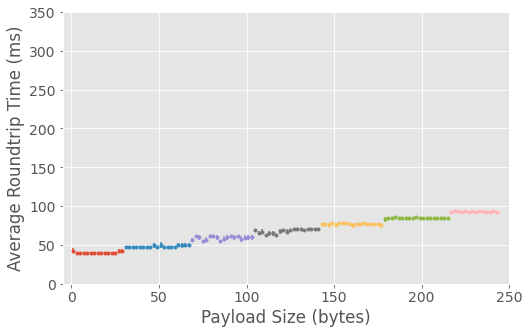

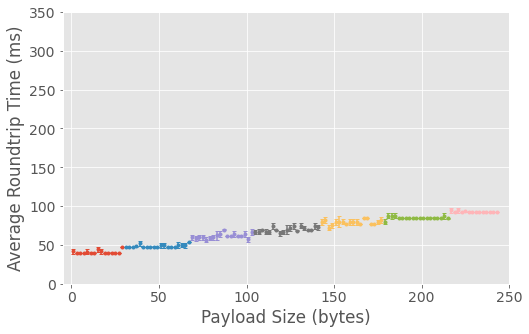

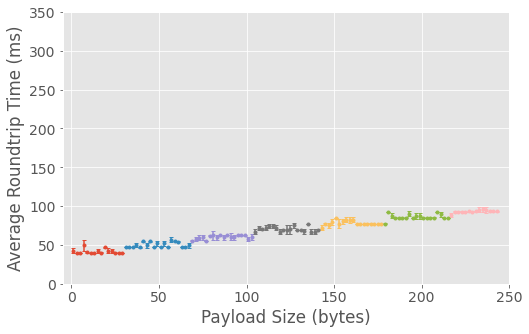

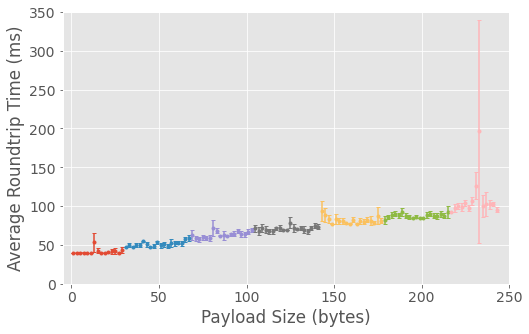

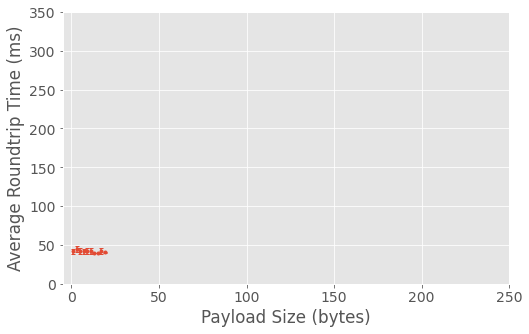

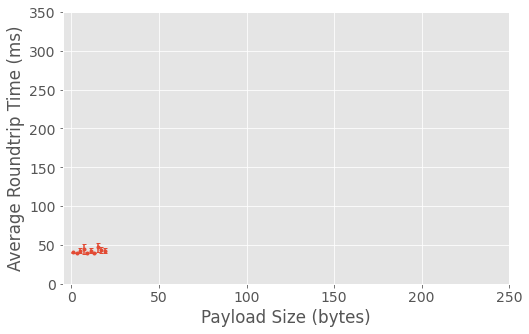

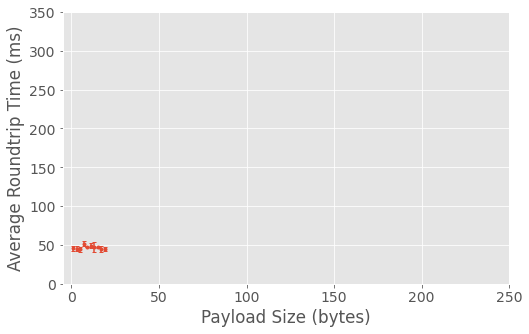

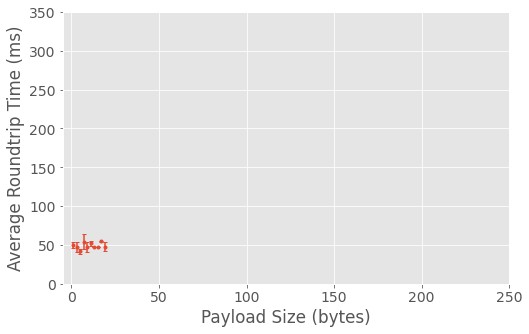

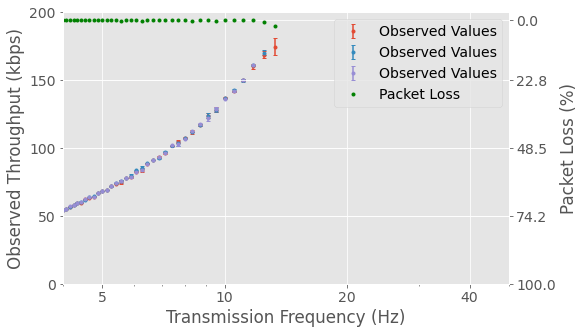

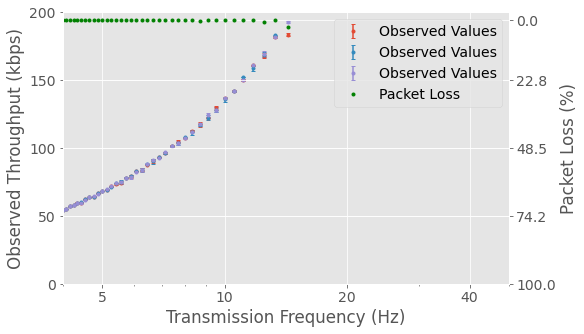

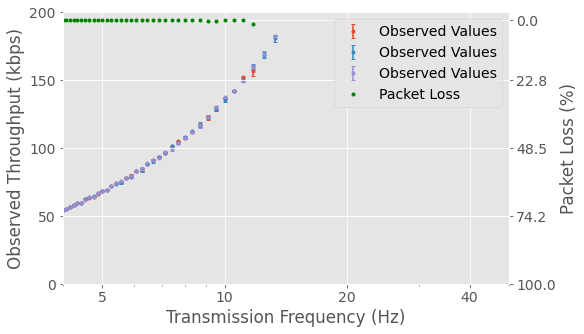

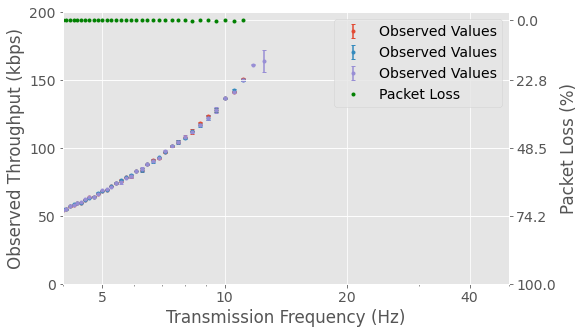

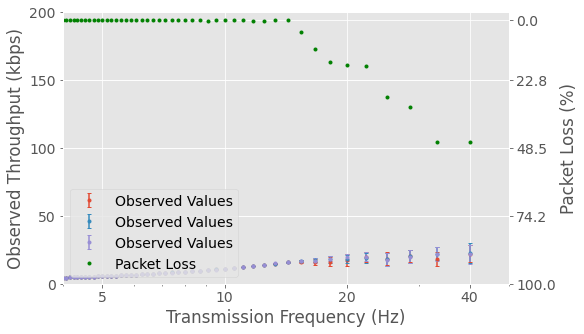

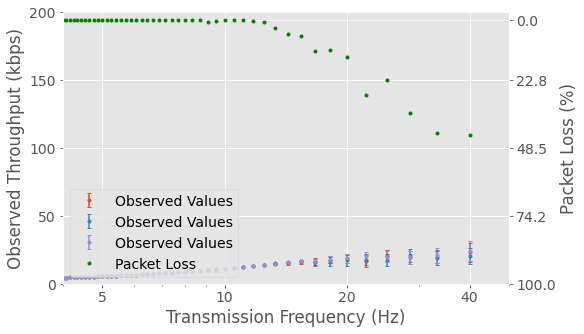

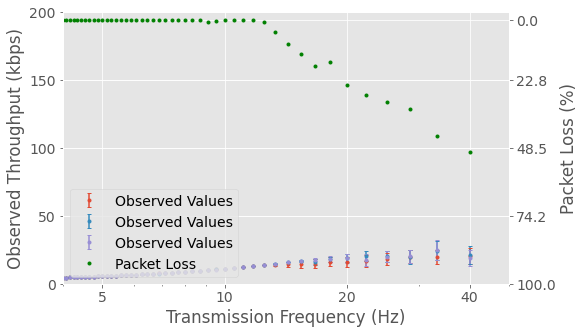

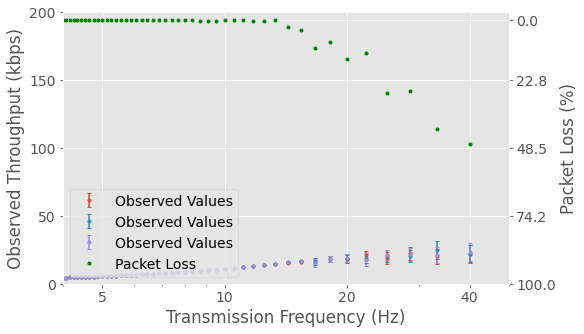

In [71]:

roundtriptest_results = pd.DataFrame()
bwtest_finalresults = pd.DataFrame()

plt.rcParams.update({'font.size': 14})

roundtrip_timearr = []

tests = ['roundtrip', 'bandwidth']
for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                if test == "roundtrip":
                    data = roundtrip_tests[(roundtrip_tests[adapter_header] == adapter) & (roundtrip_tests[distance_header] == distance) & (roundtrip_tests[physicalLayer_header] == phy) & (roundtrip_tests[payloadSize_header] <= 244)]
                    
                    roundtripTimes = np.array([])
                    payloadSizes = np.array([])
                    stdRoundtripTimes = np.array([])

                    fig = plt.figure(figsize=[8,5])#(figsize=[8,8])
                    axis = fig.add_subplot()
                    #axis.set_title(r"Roundtrip - {}cm".format(distance))
                    
                    #fig1 = plt.figure()#(figsize=[8,8])
                    #axis1 = fig1.add_subplot()
                    #axis1.set_title(r"Bandwidth - {}cm".format(distance))
                    if (adapter == 'hci0'):
                        if (distance == 0):
                            for payloadSize in data[payloadSize_header]:
                                roundtripTime = data[data[payloadSize_header] == payloadSize][roundtripTime_header].to_numpy()[0]
                                stdRoundtripTime = data[data[payloadSize_header] == payloadSize][stdRoundtripTime_header].to_numpy()[0]
                                #print(roundtripTime, np.sqrt(np.sum((roundtripTimes - roundtripTime)**2 / len(roundtripTimes))))

                                if (len(roundtripTimes) == 0):
                                    roundtripTimes = np.append(roundtripTimes, roundtripTime)
                                    payloadSizes = np.append(payloadSizes, payloadSize)
                                    stdRoundtripTimes = np.append(stdRoundtripTimes, stdRoundtripTime)
                                    
                                # 6ms difference, I initially used the 7.5 ms connection interval, but this seems to fit better to the results
                                elif (abs(np.sqrt(np.sum((roundtripTimes - roundtripTime)**2 / len(roundtripTimes)))) > 0.0055):
                                    #axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                                    #axis.plot(payloadSizes, 1000*roundtripTimes, 'o', markersize=3)
                                    axis.errorbar(payloadSizes, 1000*roundtripTimes, yerr=1000*stdRoundtripTimes, fmt='o', markersize=3)
                                    roundtriptest_currentresult = {}
                                    roundtriptest_currentresult["First Payload Size (bytes)"] = payloadSizes[0]
                                    roundtriptest_currentresult["Max Payload Size (bytes)"] = payloadSizes[-1]       
                                    roundtriptest_currentresult["Payload Size Diff (bytes)"] = (payloadSizes[-1] - payloadSizes[0]) + 1
                                    roundtriptest_currentresult["Average Roundtrip Time (s)"] = np.average(roundtripTimes)
                                    roundtriptest_currentresult["Standard Dev Roundtrip Time"] = np.std(roundtripTimes)
                                    roundtriptest_currentresult[physicalLayer_header] = phy
                                    roundtriptest_currentresult[distance_header] = distance
                                    roundtriptest_currentresult[adapter_header] = adapter


                                    roundtriptest_results = roundtriptest_results.append(pd.DataFrame([roundtriptest_currentresult]), ignore_index=True)

                                    # reset buffers
                                    roundtripTimes = np.array([roundtripTime,])
                                    payloadSizes = np.array([payloadSize,])
                                    stdRoundtripTimes = np.array([stdRoundtripTime,])
                                else:
                                    roundtripTimes = np.append(roundtripTimes, roundtripTime)
                                    payloadSizes = np.append(payloadSizes, payloadSize)
                                    stdRoundtripTimes = np.append(stdRoundtripTimes, stdRoundtripTime)
    
                            if (len(payloadSizes) > 1):
                                #axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                                #axis.plot(payloadSizes, 1000*np.array(roundtripTimes), 'o', markersize=3)
                                roundtriptest_currentresult = {}
                                roundtriptest_currentresult["First Payload Size (bytes)"] = payloadSizes[0]
                                roundtriptest_currentresult["Max Payload Size (bytes)"] = payloadSizes[-1]       
                                roundtriptest_currentresult["Payload Size Diff (bytes)"] = (payloadSizes[-1] - payloadSizes[0]) + 1
                                roundtriptest_currentresult["Average Roundtrip Time (s)"] = np.average(roundtripTimes)
                                roundtriptest_currentresult["Standard Dev Roundtrip Time"] = np.std(roundtripTimes)
                                roundtriptest_currentresult[physicalLayer_header] = phy
                                roundtriptest_currentresult[distance_header] = distance
                                roundtriptest_currentresult[adapter_header] = adapter

                                roundtriptest_results = roundtriptest_results.append(pd.DataFrame([roundtriptest_currentresult]), ignore_index=True)

                                axis.errorbar(payloadSizes, 1000*roundtripTimes, yerr=1000*stdRoundtripTimes, fmt='o', markersize=3, capsize=2)
                        else:
                            #print(adapter, distance)
                            # grab data from distance 0
                            data_rtt = roundtriptest_results[(roundtriptest_results[distance_header] == 0) & (roundtriptest_results[adapter_header] == adapter)]
                            #print(data_rtt)
                            for stepmin, stepmax in zip(data_rtt["First Payload Size (bytes)"], data_rtt["Max Payload Size (bytes)"]):
                                stepping_data = data[(data[payloadSize_header] >= stepmin) & (data[payloadSize_header] <= stepmax)]
                                #axis.plot(stepping_data[payloadSize_header], 1000*stepping_data[roundtripTime_header], 'o', markersize=3)
                                axis.errorbar(stepping_data[payloadSize_header], 1000*stepping_data[roundtripTime_header], yerr=1000*stepping_data[stdRoundtripTime_header], fmt='o', markersize=3, capsize=2)

                    else:
                        axis.errorbar(data[payloadSize_header], 1000*data[roundtripTime_header],yerr=1000*data[stdRoundtripTime_header], fmt='o', markersize=3, capsize=2)
                        
                    axis.set_xlabel(r'Payload Size (bytes)')
                    axis.set_ylabel(r'Average Roundtrip Time (ms)')
                    #axis.xaxis.label.set_fontsize(20)
                    #axis.yaxis.label.set_fontsize(20)

                    #axis.set_title("Distance: {}m".format(int(distance/100)))
                    #axis1.set_xlabel(r'Payload Size (bytes)')
                    #axis1.set_ylabel(r'Minimum Estimated Bandwidth (kbps)')
                    axis.set_ylim(0, 350)
                    axis.set_xlim(-5, 250)
                    fig.savefig(r"ble-roundtrip-{}-{}cm.pdf".format(adapter, distance))
                    #fig1.savefig(r"ble-pseudo-bandwidth-{}cm.pdf".format(distance))
                if test == "bandwidth":
                    data_allruns = bandwidthtest_results[(bandwidthtest_results[adapter_header] == adapter) & (bandwidthtest_results[distance_header] == distance)]

                    payloadSize = data_allruns[payloadSize_header].mean()
                    #testruns = [data_allruns[bandwidthTestRunIndex_header].unique()[0], ]
                    testruns = data_allruns[bandwidthTestRunIndex_header].unique()

                    fig = plt.figure(figsize=[8,5])#(figsize=[8,8])
                    axis = fig.add_subplot()
                    axis.set_xscale('log')
                    axis.set_ylim(None, 250, auto=True)
                    axis.set_xlim(4, 50)
                    
                    twinaxis = axis.twinx()
                    
                    nticks = 5
                    #axis.yaxis.set_major_locator(ticker.LinearLocator(nticks))
                    #twinaxis.yaxis.set_major_locator(ticker.LinearLocator(nticks))

                    axis.set_xlabel(r'Transmission Frequency (Hz)')
                    #axis.set_xlabel(r'Time between Data Packets (ms)')
                    #axis.set_xlabel(r'Time between Data Packets (ms)')
                    #if (adapter == 'hci0'):
                    #    axis.set_xlim(0, 250)
                        #axis.set_ylim(-0.4, 5)
                    #else:
                    #    axis.set_xlim(0, 250)
                        #axis.set_ylim(-2, 50)
                    #axis.invert_xaxis()
                    #axis.invert_yaxis()
                    
                    #axis.xaxis.label.set_fontsize(20)
                    #axis.yaxis.label.set_fontsize(20)
                    #axis.set_ylabel(r'Packet Loss (%)')
                    axis.set_ylabel(r'Observed Throughput (kbps)')
                    axis.set_ylim(0, 200)
                    twinaxis.set_ylim(-3, 100)

                    axis.yaxis.set_ticks([0, 50, 100, 150, 200])
                    twinaxis.yaxis.set_ticks([0, 22.8, 48.5, 74.2, 100])
                    
                    twinaxis.invert_yaxis()
                    twinaxis.set_ylabel(r'Packet Loss (%)')

                    #data_allruns[[bandwidthTestRunIndex_header, observedTimeBetweenPackets_header]]

                    for testRunIndex in testruns:

                        plotdata = data_allruns[
                        (data_allruns[bandwidthTestRunIndex_header] == testRunIndex)]

                        tempdata = plotdata.copy()
                        #tempdata['test'] =((100-tempdata[packetLoss_header]).divide(plotdata[expectedTimeBetweenPackets_header], axis=0, fill_value = None)).mul(payloadSize*10*8*7/1000)

                        #tempdata['test_std'] =((tempdata[stdPacketLoss_header]).divide(plotdata[expectedTimeBetweenPackets_header], axis=0, fill_value = None)).mul(payloadSize*10*8*7/1000)
                        
                        tempdata['test'] = (payloadSize*8*7) / plotdata[observedTimeBetweenPackets_header]

                        tempdata['test_std'] = (payloadSize*8*7) * plotdata[observedTimeStdBetweenPackets_header]/ (plotdata[observedTimeBetweenPackets_header]**2)

                        #print (tempdata['test'], tempdata['test_std'])
                        maxbwval = tempdata[tempdata['test']==tempdata['test'].max()]

                        print("dist:{}, adap:{}) bandwidth {} (+-{}) kbps, time between packets {} (->{}) ms, packet loss {} %".format(distance, adapter, round_num(float(maxbwval['test'])), round_num(float(maxbwval['test_std'])), float(maxbwval[expectedTimeBetweenPackets_header]), round_num(round_num(float(maxbwval[observedTimeBetweenPackets_header]))), round_num(float(maxbwval[packetLoss_header]))))

                        bwtest_finalresults = bwtest_finalresults.append(maxbwval, ignore_index=True)
                        
                        #print(plotdata[expectedTimeBetweenPackets_header])
                        #axis.errorbar(1000/plotdata[expectedTimeBetweenPackets_header], tempdata['test'], yerr=tempdata['test_std'], fmt='o', markersize=3, label='Run {}#'.format(testRunIndex))
                        axis.errorbar(1000/plotdata[expectedTimeBetweenPackets_header], tempdata['test'], yerr=tempdata['test_std'], fmt='o', markersize=3, label='Observed Values', capsize=2)
                        #axis.plot(1000/plotdata[expectedTimeBetweenPackets_header], tempdata['test'], 'o', markersize=3, label='Run {}'.format(testRunIndex))
                        #axis.plot(plotdata[expectedTimeBetweenPackets_header], plotdata[packetLoss_header], 'o', markersize=2, label='Run {}'.format(testRunIndex))
                        #print("(adapter: {}, d:{}, pd:{}) Min value: {} ms Max Bandwidth: {} bps, Packet Loss {}%".format(adapter, distance, payloadSize, plotdata[expectedTimeBetweenPackets_header].min(), ((100-plotdata[packetLoss_header]).divide(plotdata[expectedTimeBetweenPackets_header], axis=0, fill_value = None)).mul(payloadSize*10*8*7).max(), plotdata[packetLoss_header]))
                        
                        

                        #axis.plot(plotdata[expectedTimeBetweenPackets_header], 100-(plotdata[expectedTimeBetweenPackets_header] / plotdata[observedTimeBetweenPackets_header]).clip(upper=1)*100, 'o', markersize=2, label='Run {}'.format(testRunIndex))
                        #axis.set_ylim(-0.3, 5)
                        #axis.set_xlim(plotdata[expectedTimeBetweenPackets_header].min() - 50, plotdata[expectedTimeBetweenPackets_header].max() +50)

                    twinaxis.plot(1000/data_allruns[data_allruns[bandwidthTestRunIndex_header] == testruns[0]][expectedTimeBetweenPackets_header], data_allruns[data_allruns[bandwidthTestRunIndex_header] == testruns[0]][packetLoss_header], 'og', label="Packet Loss",  markersize=3)

                    #axis.plot(1000/plotdata[expectedTimeBetweenPackets_header], ((payloadSize*8*7) / ((plotdata[expectedTimeBetweenPackets_header] // 7.5)*7.5)), '--', label='Theoretical Curve')

                    #axis.set_title("Distance: {}m".format(int(distance/100)))
                    #axis.legend(loc=(0.025, 0.5))
                    lines, labels = axis.get_legend_handles_labels()
                    lines2, labels2 = twinaxis.get_legend_handles_labels()
                    if (adapter == "hci1"):
                        twinaxis.legend(lines + lines2, labels + labels2)#, loc=(0.025, 0.3))
                    else:
                        twinaxis.legend(lines + lines2, labels + labels2)#, loc=(0.6, 0.025))
                    
                    axis.xaxis.set_ticks([5, 10, 20, 40])
                    #twinaxis.set_xtick_labels([x if x != -3 else 0 for x in twinaxis.get_xticks()])
                    for axes in [axis.xaxis, axis.yaxis]:
                       axes.set_major_formatter(ScalarFormatter())
                    #twinaxis.legend(loc=(0.3, 0.73))
                    #twinaxis.xaxis.get_major_formatter().labelOnlyBase = False
                    fig.savefig(r"ble-bandwidth-{}-{}cm.pdf".format(adapter, distance))


#print(roundtriptest_results)

In [57]:
#print(roundtripTimes)
np.array(roundtripTimes).dtype
#print(np.array(roundtripTimes), 1000*np.array(roundtripTimes), np.array(stdRoundtripTimes).size(), np.array(stdRoundtripTimes))

dtype('float64')

In [58]:
for adapter in adapters:
    for distance in distances:
        data = maxbwval[(maxbwval[distance_header]==distance) & (maxbwval[adapter_header]==adapter)]
        #print(maxbwval)
        print("dist:{}, adap:{}) bandwidth {}(+-{})bps, ".format(distance, adapter, float(data['test'].mean()), float(data['test'].std())))

dist:0, adap:hci0) bandwidth nan(+-nan)bps, 
dist:300, adap:hci0) bandwidth nan(+-nan)bps, 
dist:600, adap:hci0) bandwidth nan(+-nan)bps, 
dist:900, adap:hci0) bandwidth nan(+-nan)bps, 
dist:0, adap:hci1) bandwidth nan(+-nan)bps, 
dist:300, adap:hci1) bandwidth nan(+-nan)bps, 
dist:600, adap:hci1) bandwidth nan(+-nan)bps, 
dist:900, adap:hci1) bandwidth 23.256610014598422(+-nan)bps, 


In [59]:

# analyse roundtrip results
#data = roundtriptest_results[roundtriptest_results[distance_header] == 0]
#data.drop(0, inplace=True)
#print(roundtriptest_results)

for distance in roundtriptest_results[distance_header].unique():
    data = roundtriptest_results[roundtriptest_results[distance_header] == distance].reset_index()
    data.drop([0], inplace=True)
    print("(d:{}) Payload Size Diff: {} +- {}".format(distance, np.average(data["Payload Size Diff (bytes)"]), np.std(data["Payload Size Diff (bytes)"])))
    print("(d:{}) Average Roundtrip Time Diff (ms): {} +- {}".format(distance, 1000*np.average(data["Average Roundtrip Time (s)"].diff().dropna()), 1000*np.std(data["Average Roundtrip Time (s)"].diff().dropna())))


(d:0) Payload Size Diff: 34.666666666666664 +- 3.5433819375782165
(d:0) Average Roundtrip Time Diff (ms): 8.945516541353388 +- 1.1555115933484652


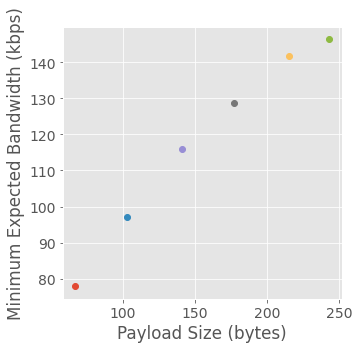

In [60]:

fig = plt.figure(figsize=[5,5])
axis = fig.add_subplot()

data = roundtriptest_results[roundtriptest_results[distance_header] == 0].reset_index()
data.drop(0, inplace=True)

for idx in data.index:
    row = data.loc[idx]
    bandwidth_avg = (row["Max Payload Size (bytes)"] / (1000*row["Average Roundtrip Time (s)"]))*7*8
    axis.set_xlabel(r'Payload Size (bytes)')
    axis.set_ylabel(r'Minimum Expected Bandwidth (kbps)')
    axis.plot(row["Max Payload Size (bytes)"], bandwidth_avg, 'o')